### Import Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
from flask import Flask, jsonify

### Reflect Tables into SQLAlchemy ORM


In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Instructions/Resources/hawaii.sqlite")
conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Exploratory Climate Analysis

In [11]:
# viewing column names

inspector = inspect(engine)
inspector.get_table_names()
columns_measurement = inspector.get_columns('measurement')
columns_station = inspector.get_columns('station')

print("MEASUREMENT COLUMNS")
print('___________________')   
for column in columns_measurement:    
    print(column["name"], column["type"])
print('')   
print("STATION COLUMNS")
print('_______________')   
for column in columns_station:   
    print(column["name"], column["type"])

MEASUREMENT COLUMNS
___________________
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

STATION COLUMNS
_______________
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Design a query to retrieve the last 12 months of precipitation data and plot the results

### Perform a query to retrieve the data and precipitation scores

In [12]:
# Identify Last Date, so you can find 1 year earlier

results = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp,Measurement.tobs).\
    order_by(Measurement.date.desc()).all()

# Calculate the date 1 year ago from the last data point in the database
last_date = [result[2] for result in results[:1]]
last_day = dt.datetime.strptime(last_date[0], "%Y-%m-%d")
one_year = dt.timedelta(days=365)
year_ago = last_day - one_year

last_year = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp,Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()



## SIDE QUEST: Vewing the filterd Data as printed text

In [13]:
first_measure = [result[0:5] for result in last_year[:1]]
last_day_measure = [result[0:5] for result in results[:1]]
print('')
print('Initial Report')
print('______________')

first_date  = [date[2] for date in last_year[:1]]
print(f'First Measurement: {first_measure}')
print(f'Final Measurement: {last_day_measure}')
print(f'First Date: {year_ago}')
print(f'Last Date: {last_day}')

print('')
print(f'Observation View (Last 10)')
print('_______________________________________')
print('ID   | Station   | Date     |Prcp|T Obs')
print('---------------------------------------')
for reading in last_year:
    if reading.id > 19540:
        print(reading.id, reading.station, reading.date, reading.prcp, reading.tobs)


Initial Report
______________
First Measurement: [(2365, 'USC00519397', '2016-08-24', 0.08, 79.0)]
Final Measurement: [(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)]
First Date: 2016-08-23 00:00:00
Last Date: 2017-08-23 00:00:00

Observation View (Last 10)
_______________________________________
ID   | Station   | Date     |Prcp|T Obs
---------------------------------------
19541 USC00516128 2017-08-14 0.22 79.0
19542 USC00516128 2017-08-15 0.42 70.0
19543 USC00516128 2017-08-16 0.42 71.0
19544 USC00516128 2017-08-17 0.13 72.0
19545 USC00516128 2017-08-18 None 76.0
19546 USC00516128 2017-08-19 0.09 71.0
19547 USC00516128 2017-08-20 None 78.0
19548 USC00516128 2017-08-21 0.56 76.0
19549 USC00516128 2017-08-22 0.5 76.0
19550 USC00516128 2017-08-23 0.45 76.0


In [14]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
# Save the query results as a Pandas DataFrame and set the index to the date column

last_year_prcp = pd.DataFrame(last_year)
last_year_prcp.dropna(inplace=True)
annual_analysis = last_year_prcp.rename(columns = {'prcp':'Precipitation'})
annual_analysis.drop(columns=['id','station','tobs'], inplace=True)
annual_analysis.set_index('date', inplace=True)
annual_analysis.to_sql(name='precipitation', con=engine, if_exists='replace', index_label='date')
precipitation = annual_analysis.groupby(level='date').mean()
precipitation.rename(columns = {'Precipitation':'Avg_Daily_Prcp'}, inplace=True)
print('Table 1. First 15 Readings\nTable 2. Most recent 15 Readings\nTable 3. Start of Year Avg Daily Precipitation\nTable 4. End of Year Avg Daily Precipitation')
display_side_by_side(annual_analysis.head(15),annual_analysis.tail(15), precipitation.head(15),precipitation.tail(15))
display_side_by_side()

Table 1. First 15 Readings
Table 2. Most recent 15 Readings
Table 3. Start of Year Avg Daily Precipitation
Table 4. End of Year Avg Daily Precipitation


,Precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08
2016-08-25,0.00


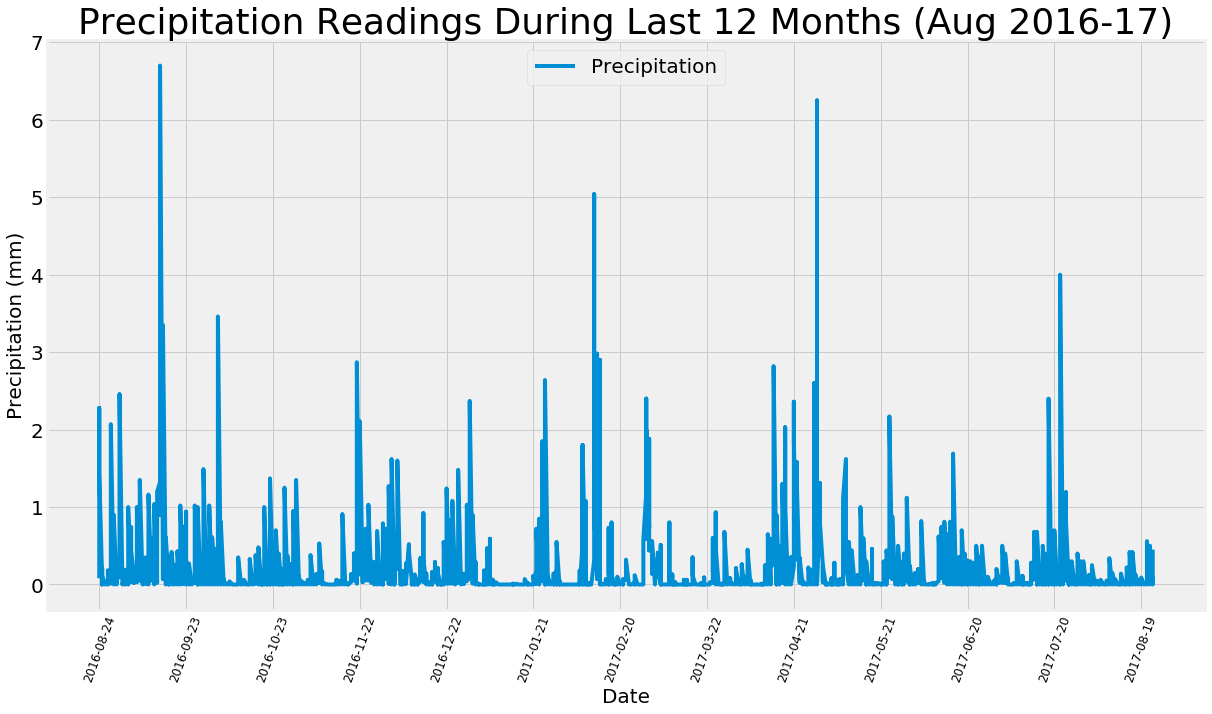

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(annual_analysis.index, annual_analysis['Precipitation'])
plt.title('Precipitation Readings During Last 12 Months (Aug 2016-17)', fontsize=36)
plt.xlabel('Date', fontsize=20)
plt.xticks(np.arange(0, 365, 30), rotation=70, fontsize=12)
plt.yticks(fontsize=20)
plt.ylabel('Precipitation (mm)', fontsize=20)
plt.legend(loc=9, prop={'size': 20})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
fig.savefig('prcp_readings.png', dpi=100)
plt.show()
plt.close()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
annual_analysis.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis
## --------------------------------------

#### Design a query to show how many stations are available in this dataset?

In [17]:
num_stations = session.query(Measurement.station).distinct().count()
print(f'SQLAlchemy says: {num_stations}')

print('')

results = pd.DataFrame(results)
pandas_count = results['station'].nunique()
print(f'Pandas says: {pandas_count}')

SQLAlchemy says: 9

Pandas says: 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
print('SQLAlchemy says:')

num_stations = session.query(Measurement.station, func.count(Measurement.id))\
                .group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
display(num_stations)

top_station = session.query(Measurement.station, func.count(Measurement.id))\
                .group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()

print(f'The Station with the most observations, follwed by total observations, is: {top_station}')

print('')
# List the stations and the counts in descending order.
print('Pandas says:')
top_stations = results.drop(columns=['prcp','date','tobs'])
top_stations.groupby(['station']).count().sort_values(['id'], ascending=False)

SQLAlchemy says:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

The Station with the most observations, follwed by total observations, is: ('USC00519281', 2772)

Pandas says:


,id
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


### Using the station id from the previous query, calculate 
* (1) the lowest temperature recorded, 
* (2) highest temperature recorded, and 
* (3) average temperature at the most active station?


#### (1) the lowest temperature recorded at the most active station

In [19]:
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(lowest_temp)

lowest_temp_record = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(lowest_temp_record)

[(54.0)]

[(13294, 'USC00519281', '2013-01-16', 0.02, 54.0)]

#### (2) highest temperature recorded

In [20]:
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(highest_temp)

highest_temp_record = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(highest_temp_record)

[(85.0)]

[(14261, 'USC00519281', '2015-09-10', 0.09, 85.0)]

#### (3) average temperature at the most active station?

In [21]:
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(avg_temp)

avg_temp_record = session.query(Measurement.id, Measurement.station, Measurement.date, func.avg(Measurement.prcp), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
display(avg_temp_record)

[(71.66378066378067)]

[(12188, 'USC00519281', '2010-01-01', 0.2123520923520915, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [23]:
print('SQLAlchemy says:')

top_station = session.query(Measurement.station, func.count(Measurement.id))\
                .group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()


active_station_last_year = session.query(Measurement.date, Measurement.tobs)\
                                        .filter(Measurement.date >= year_ago)\
                                        .filter(Measurement.station == 'USC00519281')\
                                        .filter(Measurement.tobs.isnot(None))\
                                        .order_by(Measurement.date).all()
display(active_station_last_year[0:10])

print('Pandas says:')
asly_temp_obs = pd.DataFrame(np.array(active_station_last_year), columns=(["date","temp_obs"]))

asly_temp_obs.temp_obs = asly_temp_obs.temp_obs.astype(float)
asly_temp_obs.head(10)

SQLAlchemy says:


[('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0),
 ('2016-09-02', 80.0)]

Pandas says:


,date,temp_obs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
5,2016-08-29,78.0
6,2016-08-30,77.0
7,2016-08-31,78.0
8,2016-09-01,80.0
9,2016-09-02,80.0


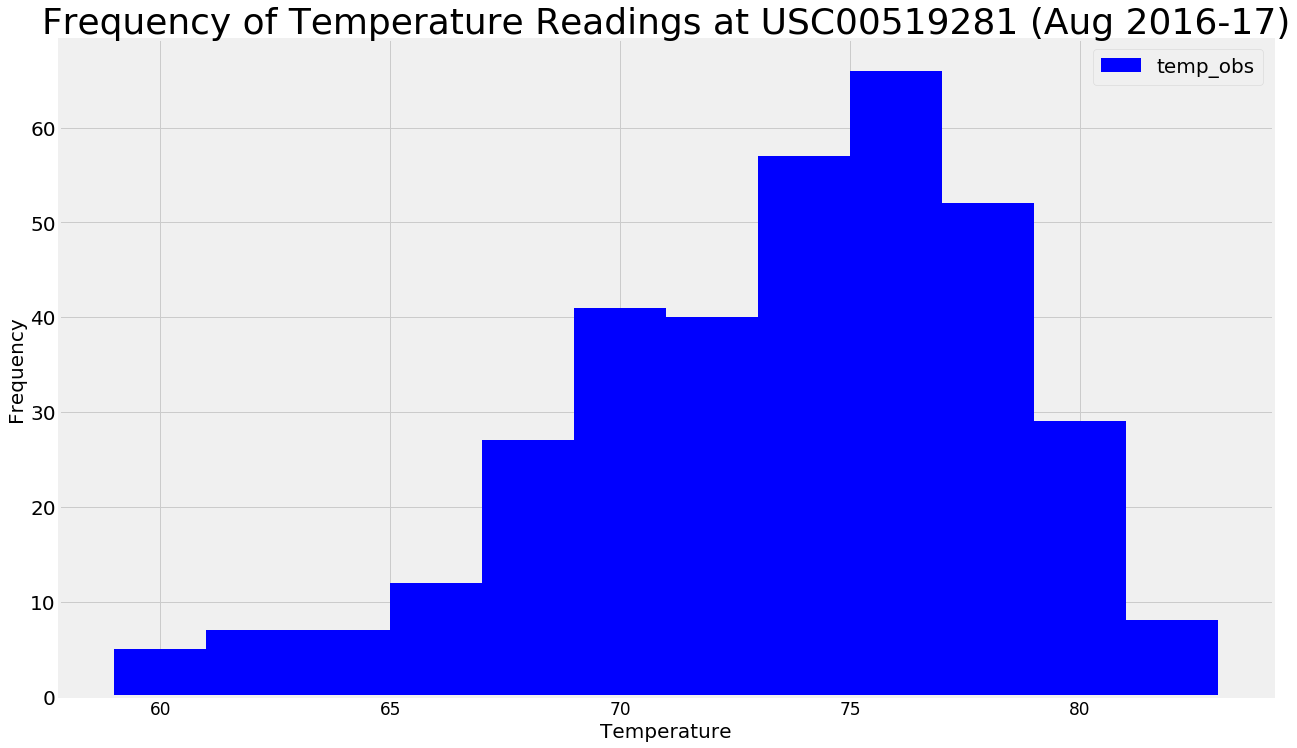

In [24]:
asly_temp_obs.plot.hist(by=None, bins=12, figsize=(15, 13), color="blue", fontsize=17)

plt.title('Frequency of Temperature Readings at USC00519281 (Aug 2016-17)', fontsize=36)
plt.xlabel('Temperature', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend(loc='best', prop={'size': 20})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.tight_layout()
plt.savefig("temp_obs_histogram.png")
plt.show()
plt.close()

### Optional: Other Recommended Analyses

* The following are optional challenge queries. These are highly recommended to attempt, but not required for the homework.


### Temperature Analysis

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps(year_ago, last_day))
temp_predictor = calc_temps(year_ago, last_day)


[(58.0, 74.57894736842105, 87.0)]


In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

,Min,Avg,Max
Prediction,58.0,74.6,87.0


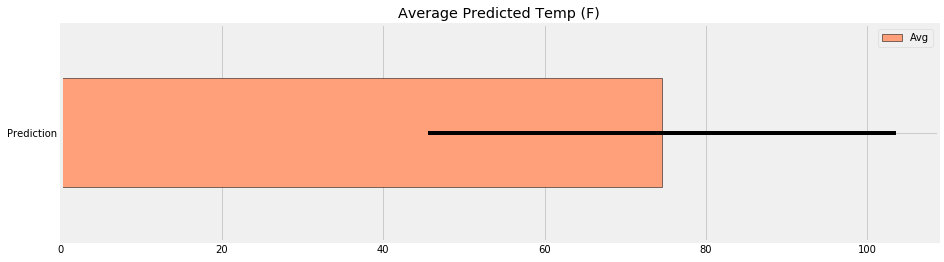

In [124]:
temp_list = temp_predictor[0]
temp_min = temp_list[0]
temp_avg = temp_list[1]
temp_max = temp_list[2]
center = (temp_avg)/2
error_t = temp_max - temp_min

trip_temps = pd.DataFrame({'Min': round(temp_min,1) , 'Avg': round(temp_avg,1), 'Max': round(temp_max,1) }, index=["Prediction"])
predictor = trip_temps.round(2)
display(predictor)
trip_temps.plot.barh(y='Avg', xerr=error_t, edgecolor='black', facecolor='lightsalmon', align='center')
plt.title('Average Predicted Temp (F)')

fig = plt.gcf()
fig.set_size_inches(14, 4)
plt.savefig("trip_temp_predictor.png")
plt.show()
plt.close()

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

# Mansi wrote the remaining code, so I get no credit, and I wouldn't have figured it out without her

#### I tried to figure out how to use input()s for the dates, but it never worked (or rather worked only once, but my guess is that means it wasn't working)

#### Set the start and end date of the trip

In [ ]:
trip_begins = input('Enter Trip Start Date as YYYY-MM-DD')

In [ ]:
trip_ends = input('Enter Trip End Date as YYYY-MM-DD')

In [105]:
trip_begins = '2016-08-23'
trip_ends = '2017-08-23'
start_that_trip = dt.datetime.strptime(trip_begins, '%Y-%m-%d')
home_again_home_again = dt.datetime.strptime(trip_ends, '%Y-%m-%d')

In [151]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2016-01-15'
end_date ='2016-06-15'
# Use the start and end date to create a range of dates

dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()

# List comprehension to get the elements in the tuple from the dates query 
trip_dates = [x[0] for x in dates]

# Stip off the year and save a list of %m-%d strings with another list comprehension 
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]


#daily_normals = [session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()]
    
# Loop through the list of %m-%d strings and calculate the normals for each date    
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals")
daily_normals

Aggregate Daily Normals


[(56.0, 69.31372549019608, 78.0),
 (54.0, 68.62962962962963, 80.0),
 (61.0, 69.07407407407408, 76.0),
 (57.0, 68.63157894736842, 77.0),
 (60.0, 68.26315789473684, 78.0),
 (61.0, 68.86666666666666, 78.0),
 (61.0, 70.14545454545454, 76.0),
 (60.0, 69.26415094339623, 76.0),
 (57.0, 69.50909090909092, 79.0),
 (58.0, 68.76271186440678, 78.0),
 (61.0, 67.94915254237289, 75.0),
 (61.0, 70.58620689655173, 77.0),
 (59.0, 68.56896551724138, 75.0),
 (62.0, 69.03703703703704, 77.0),
 (64.0, 69.14, 76.0),
 (60.0, 67.12962962962963, 77.0),
 (60.0, 68.47368421052632, 74.0),
 (56.0, 68.14035087719299, 78.0),
 (59.0, 68.85964912280701, 77.0),
 (58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0),
 (58.0, 70.38983050847457, 77.0),
 (60.0, 69.0, 77.0),
 (56.0, 66.75438596491227, 74.0),
 (57.0, 67.58928571428571, 75.0),
 (56.0, 68.41666666666667, 76.0),
 (61.0, 69.25, 79.0),
 (60.0, 69.15789473684211, 78.0),
 (58.0, 70.36206896551724, 80.0),
 (62.0, 70.8947368

In [152]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


# Create a dataframe from the previous query 
daily_normals_df= pd.DataFrame(daily_normals,columns=['Temp_Min', 'Temp_Avg', 'Temp_Max'])

# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df.head(10)

,Temp_Min,Temp_Avg,Temp_Max
date,,,
2016-01-15,56.0,69.313725,78.0
2016-01-16,54.0,68.629630,80.0
2016-01-17,61.0,69.074074,76.0
2016-01-18,57.0,68.631579,77.0
2016-01-19,60.0,68.263158,78.0
2016-01-20,61.0,68.866667,78.0
2016-01-21,61.0,70.145455,76.0
2016-01-22,60.0,69.264151,76.0
2016-01-23,57.0,69.509091,79.0


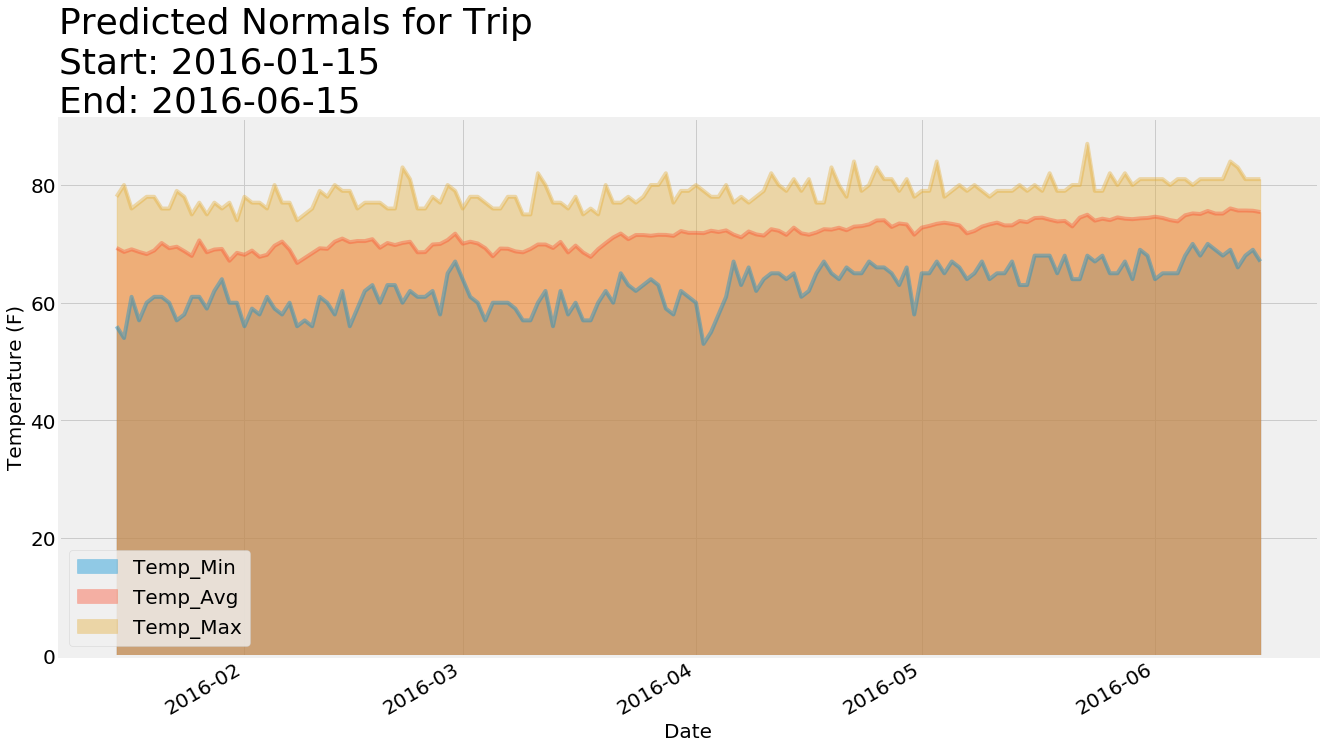

In [165]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.4, stacked=False, x_compat=True)
plt.title(f'Predicted Normals for Trip \nStart: {start_date} \nEnd: {end_date}', fontsize=36, loc='left')
plt.xlabel('Date', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Temperature (F)', fontsize=20)
plt.legend(loc='best', prop={'size': 20})

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.tight_layout()
plt.savefig("predict_surf_conditions.png")
plt.show()


